### Spatio-Temporal Variogram

First, load library and set encoding

In [2]:
library(ggplot2)
library(sqldf)
library(dplyr)
library(sp)
library(spacetime)
Sys.setlocale("LC_CTYPE", "thai")
options(encoding="UTF-8")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



[1] "Thai_Thailand.874"

Set working directory (if needed)

In [3]:
#setwd("C:\\Users\\garavig\\Documents\\Haze\\HazeAnalysis\\Data")

Load and update sensorlist id to the newest. เบอร์ของเก่าปีที่แล้วมันผิด มี 0 เยอะเกิน ต้องแก้ไขก่อน

In [4]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/sensorlist.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",1]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",1]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",1]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",1]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

Load hourly data

In [5]:
hour<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/H_Mar_PM25_2561.csv")

In [6]:
head(hour)

sensorid,date,h,pm25
CU-S0002,2018-03-01,9,43.06250
CU-S0002,2018-03-01,10,45.21875
CU-S0002,2018-03-01,11,48.02083
CU-S0002,2018-03-01,12,46.94792
CU-S0002,2018-03-01,13,44.92708
CU-S0002,2018-03-01,14,45.35417


Update time to POSIXct

In [7]:
hour$timepos <- as.POSIXct(strptime(paste(hour$date,hour$h), "%Y-%m-%d %H"))

Select only one day, then order it by sensorid and timepos respectively.

In [8]:
newhour<-hour[hour$timepos>="2018-03-08 00:00:00" & hour$timepos<="2018-03-08 23:00:00",]
newhour <- newhour[order(newhour$sensorid, newhour$timepos),]

Count number of rows per id to check the completeness of data. เช็คว่าข้อมูลทุก sensor มีครบ 24 ชั่วโมงหรือไม่

In [9]:
count<-sqldf("select sensorid,count() from newhour group by sensorid") 
colnames(count)<-c("sensorid","c")
sensorFull <-as.matrix(count[count$c == 24,]$sensorid)

Select only sensors that has 24 hour data

In [10]:
newhour<-subset(newhour,sensorid %in% sensorFull)

Check whether there is a weird value in the data.

In [31]:
sqldf("select sensorid, min(pm25), max(pm25), avg(pm25) from newhour group by sensorid")

sensorid,min(pm25),max(pm25),avg(pm25)
CU-S0002,54.89583,211.13542,103.33701
CU-S0003,81.94792,156.92708,114.85292
CU-S0004,78.12045,162.11458,115.60325
CU-S0005,74.27083,128.38542,98.63508
CU-S0006,76.26042,139.98958,96.90617
CU-S0014,81.64583,109.00000,94.01910
CU-S0015,57.27083,119.69792,99.19884
CU-S0017,80.47727,119.98958,101.82397
CU-S0018,73.77273,140.77500,98.00807
CU-S0021,80.78125,128.77083,104.08898


The model use 3 inputs:
1. Unique datetime list in order (วันที่แบบเรียงลำดับ)
2. Unique sensorid in order (id แบบ เรียงลำดับ)
3. Sensor data order by sensorid and time respectively (ข้อมูลเรียงลำดับตาม id กับ เวลา เพื่อให้เชื่อมกับ 1 กับ 2)

In [11]:
datetime<-sqldf('select distinct(timepos) from newhour') #USE THIS
sensorid<-subset(sensorlist,sensorid %in% sensorFull)
sensorid <- sensorid[order(sensorid$sensorid),]
row.names(sensorid) = sensorid$sensorid

Create a SpatialPointsDataFrame

In [12]:
coordinates(sensorid)=~lon+lat
proj4string(sensorid)=CRS("+init=epsg:4326")

In [13]:
sensoridSP <- SpatialPoints(sensorid@coords,CRS("+init=epsg:4326")) 

Create spatio-temporal using STFDF function from spacetime library

In [14]:
stdata<-STFDF(sensoridSP,datetime$timepos,data.frame(PM2.5=as.vector(newhour$pm25)),delta(datetime$timepos))

Then plot it

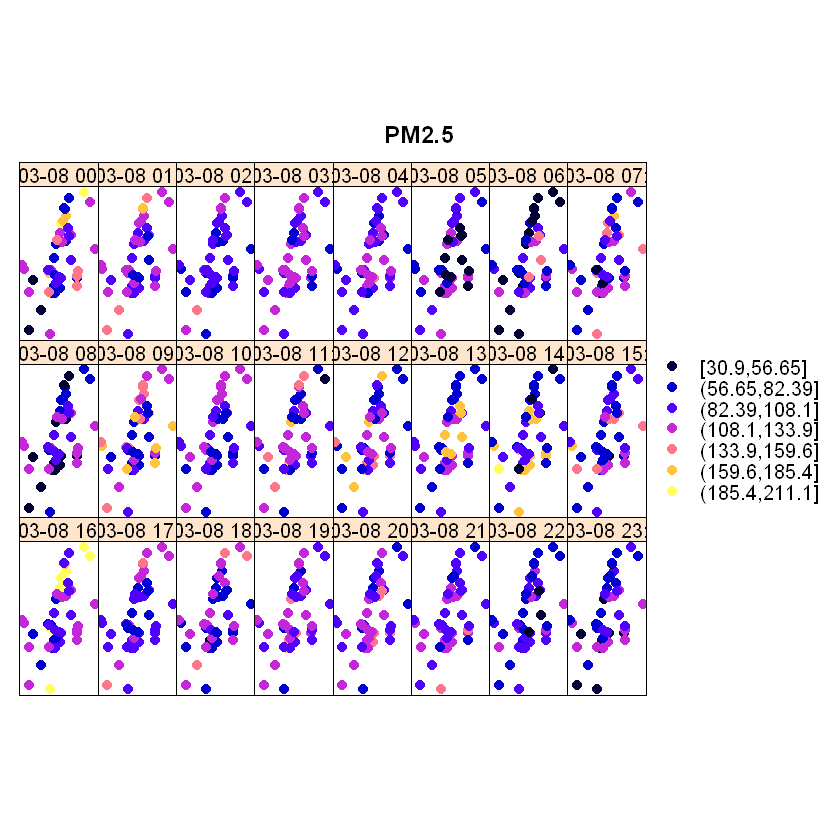

In [15]:
stplot(stdata,cuts=7)

In [16]:
summary(stdata)

Object of class STFDF
 with Dimensions (s, t, attr): (45, 24, 1)
[[Spatial:]]
Object of class SpatialPoints
Coordinates:
         min      max
lon 100.4356 101.2006
lat  18.1609  19.5797
Is projected: FALSE 
proj4string :
[+init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84
+towgs84=0,0,0]
Number of points: 45
[[Temporal:]]
     Index                       timeIndex    
 Min.   :2018-03-08 00:00:00   Min.   : 1.00  
 1st Qu.:2018-03-08 05:45:00   1st Qu.: 6.75  
 Median :2018-03-08 11:30:00   Median :12.50  
 Mean   :2018-03-08 11:30:00   Mean   :12.50  
 3rd Qu.:2018-03-08 17:15:00   3rd Qu.:18.25  
 Max.   :2018-03-08 23:00:00   Max.   :24.00  
[[Data attributes:]]
     PM2.5       
 Min.   : 30.90  
 1st Qu.: 77.31  
 Median : 95.48  
 Mean   : 99.33  
 3rd Qu.:119.93  
 Max.   :211.14  

เลือกกลุ่มแรกๆมาจากที่แบ่ง k-mean ใน 2018 Analysis

In [17]:
rn <- c("CU-S0059","CU-S0064","CU-S0046","CU-S0081","CU-S0093","CU-S0072")

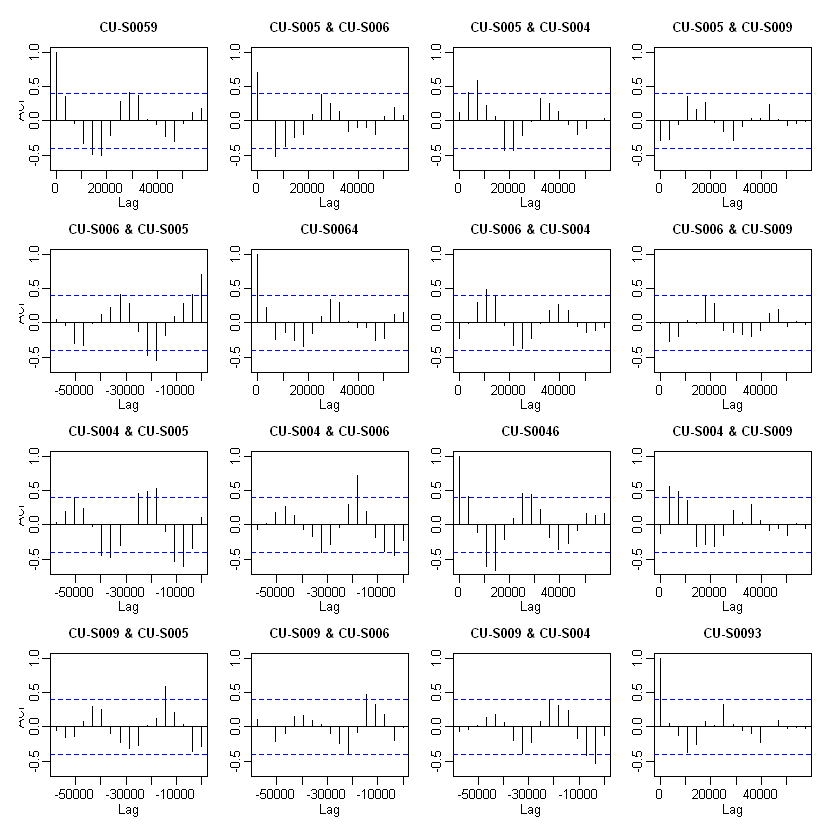

In [18]:
acf(na.omit(as(stdata[rn,],"xts")),lag=16)

In [24]:
library(gstat)
vv = variogram(PM2.5~1, stdata, width=20, cutoff = 200, tlags=0:10)

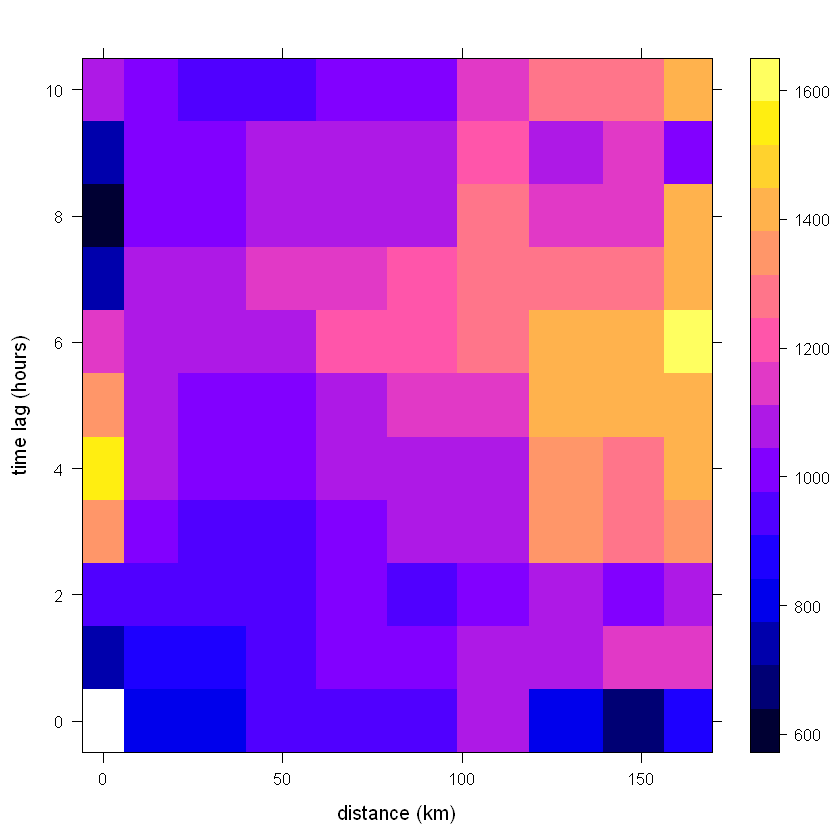

In [25]:
plot(vv)

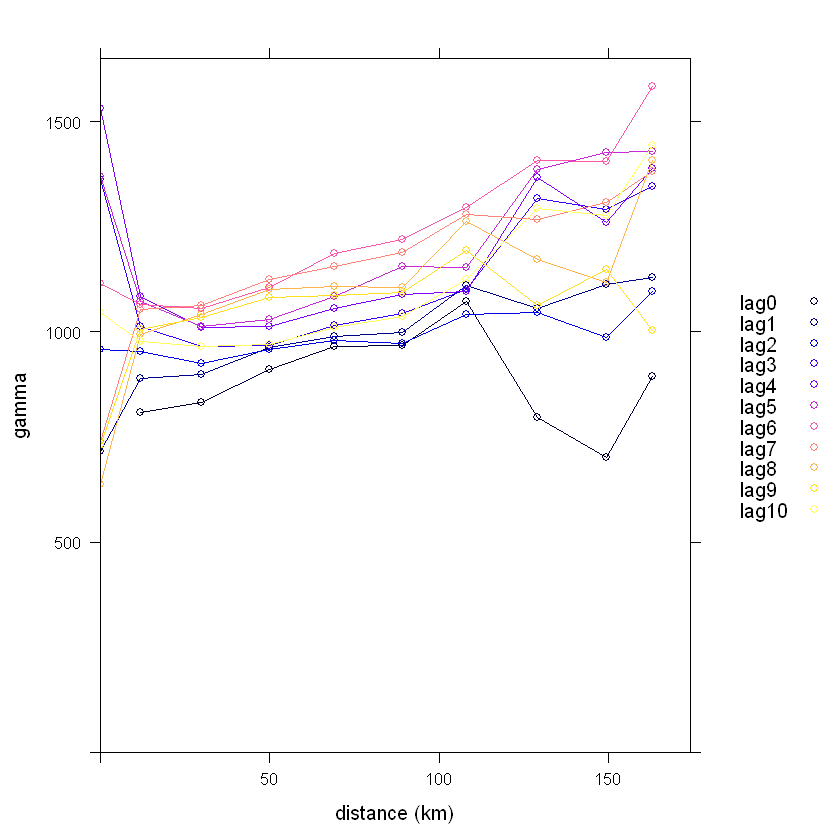

In [26]:
plot(vv, map = FALSE)

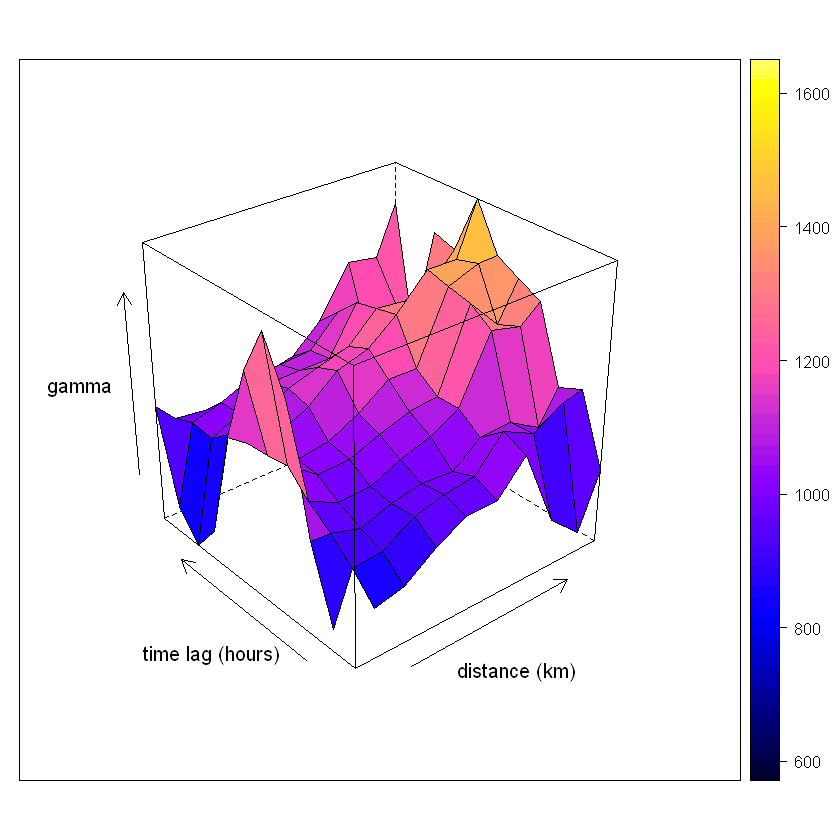

In [27]:
library(lattice)
plot(vv,all=T, wireframe=T)